# Vanilla Reinforcement Learning: Q-learning and SARSA

[Artificial Intelligence A-Z Handbook](https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/P20-AI-AZ-Handbook-Kickstarter.pdf)

This notebook is the first one related with my work in Reinforcement Learning.  
It includes a few basic experiments to understand the theorical background of reinforcement learning on toy low-dimensional examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from matplotlib.colors import ListedColormap

## Defining the environment

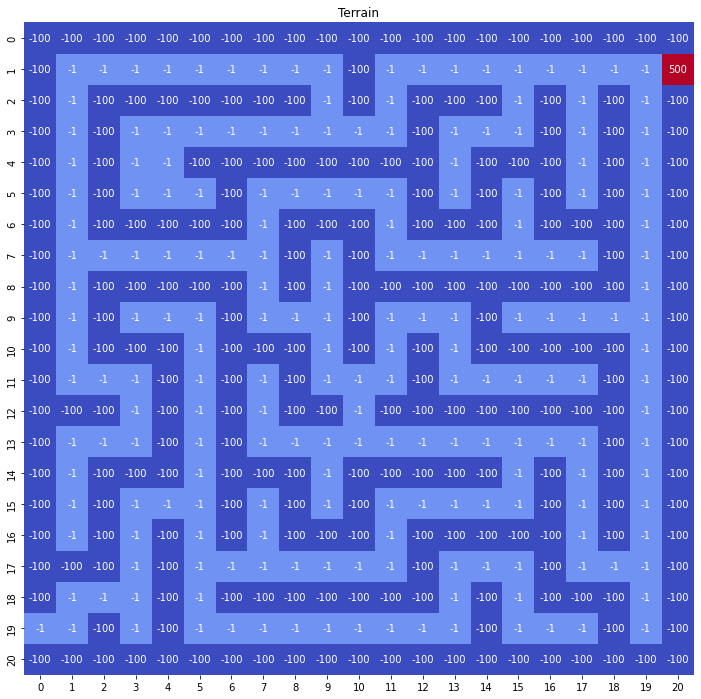

In [2]:
n_rows, n_cols = 21, 21

# BUILDING TERRAIN
terrain = np.full((n_rows, n_cols), -100) # Walls
terrain[1, 20] = 500 # Reward

# Generate paths
paths = {}
paths[1] = [i for i in range(1,10)] + [i for i in range(11, 20)]
paths[2] = [1, 9, 11, 15, 17, 19]
paths[3] = [1] + [i for i in range(3, 12)] + [13, 14, 15, 17, 19]
paths[4] = [1, 3, 4, 13, 17, 19]
paths[5] = [1, 3, 4, 5] + [i for i in range(7,12)] + [13, 15, 17, 19]
paths[6] = [1, 7, 11, 15, 19]
paths[7] = [i for i in range(1, 8)] + [9] + [i for i in range(11, 18)] + [19]
paths[8] = [1, 7, 9, 19]
paths[9] = [1] + [i for i in range(3, 6)] + [i for i in range(7, 10)] + [i for i in range(11, 14)] + [i for i in range(15, 20)]
paths[10] = [1, 5, 9, 11, 13, 19]
paths[11] = [1, 2, 3, 5, 7, 9, 10, 11] + [i for i in range(13, 18)] + [19]
paths[12] = [3, 5, 7, 10, 19]
paths[13] = [1, 2, 3, 5] + [i for i in range(7, 18)] + [19]
paths[14] = [1, 5, 9, 15, 17, 19]
paths[15] = [1, 3, 4, 5, 7, 9] + [i for i in range(11, 16)] + [17, 19]
paths[16] = [1, 3, 5, 7, 11, 17, 19]
paths[17] = [3] + [i for i in range(5, 12)] + [13, 14, 15, 17, 18, 19]
paths[18] = [1, 2, 3, 5, 13, 15, 19]
paths[19] = [0, 1, 3] + [i for i in range(5, 14)] + [15, 16, 17, 19]

for i in paths.keys():
    terrain[i, paths[i]] = -1


plt.figure(figsize=(12, 12))
plt.title('Terrain')
sns.heatmap(terrain, cbar=False,  annot=True, fmt='.0f', cmap='coolwarm')
plt.show()

### Helper functions

In [3]:
def is_terminal_position(position):
    """
    Checks if a given position is "legal" (i.e : if it's not a wall or the end of the maze)
    As path tiles correpond to a -1 reward, the function checks if the current position has correponds to a reward different from -1 
    """
    row, col = position
    return terrain[row, col] != -1


def new_starting_position():
    """
    Returns a random legal position in the maze (a non-terminal position)
    """
    row, col = np.random.randint(0, n_rows, size=2)

    while is_terminal_position((row, col)):
        row, col = np.random.randint(0, n_rows, size=2)

    return (row, col)


def move(current_position, action):
    """
    Updates the position of the Agent, given an action [up, down, left, right]
    If the agent is at the edge of the grid, he remains in the same position
    """
    row, col = current_position
    if action == 0 and row - 1 >= 0: # up
        row -= 1

    elif action == 1 and row + 1 < n_rows: # down
        row += 1

    elif action == 2 and col - 1 >= 0: # left
        col -= 1

    elif action == 3 and col + 1 < n_cols: # right
        col += 1
    
    return row, col


def softmax(x, tau=1.):
    """
    Converts an array of real to a probability distribution
    """
    return np.exp(x)**tau / np.sum(np.exp(x)**tau)


def TD(reward, future_q, current_q, discount=0.9):
    """
    Compute Temporal Difference between two states (cf : paper)
    """
    return reward + discount * future_q - current_q


def show_path(path, title='Terrain'):
    """
    Shows a path on the maze
    
    path : ndarray of tuples. Each tuple contains the (x,y) coorinates
    """
    terrain_cpy = terrain.copy()
    for pos in path:
        terrain_cpy[pos] += 400 # Highlight path

    plt.figure(figsize=(12,12))
    plt.title(title)
    sns.heatmap(terrain_cpy, annot=True, cbar=False, fmt='.0f', cmap='coolwarm')
    plt.show()

## Q-learning Training loop

**off-policy** : Distinction between behaviour and target policies
- Behaviour policy (here Softmax) is derived from the current estimate of the $Q_{t-1}(a_t,s_t)$
- Target policy (greedy) is used to update the Q-value. We use the action corresponding to the maximum Q-value of $s_{t+1}$

Notations :
- $s_t$ : Current position
- $a_t$ : Action played at time $t$
- $Q(a_t,s_t)$ : Q-value corresponding the current state and action played (It is stored in the `q_values` array)
- $s_{t+1}\sim T(a_t,s_t,.)$ : Next state following the transition function distribution. **In this specific context, transitions are deterministic.** Given a $s_t$ and an action, the agent has only one possibility for its next state
- $r_t=R(s_t,a_t)$ : Reward earned by the agent after playing action $a_t$ in state $s_t$

**Choice of the action $a_t$ to play** (Softmax policy)

Instead of choosing the actions corresponding to the maximal Q-value, the paper recommends to sample $a_t$ from the $W_s$ distribution.

$$a_t \sim W_{s_t} = Softmax^\tau (Q(s_t,.)) \hspace{20pt} \tau \geq 0$$

**Temporal difference**

$$TD_t(a_t,s_t)=r_t+\gamma\, \underset{a}{max}(Q(a,s_{t+1}))-Q(a_t,s_t)$$
where $\gamma\in [0,1]$ is the discount parameter

**Q-value update rule**

$$Q_t(a_t,s_t)=Q_{t-1}(a_t,s_t) + \alpha\, TD_t(a_t,s_t)$$

where $\alpha > 0$ is the learning rate

In [4]:
actions = ['up', 'down', 'left', 'right']
lr = 0.9 # Learning rate
discount = 0.5
n_episodes = 4000
max_iter = 150


# Initial state (function to learn)
q_values = np.zeros((n_rows, n_cols, len(actions)))


for episode in tqdm(range(n_episodes)):

    # s_t (start from a random position at the beginning of each episode)
    current_position = new_starting_position()
    it = 0

    while not is_terminal_position(current_position) and it < max_iter:
        
        # Q-values for the current state s_t
        possible_q_values = q_values[current_position]

        # a_t : [0, 1, 2, 3]
        Ws = softmax(possible_q_values)
        action = np.random.choice(np.arange(len(actions)), p=Ws)

        # Q(a_t,s_t)
        q_value = possible_q_values[action]

        # s_(t+1)
        next_position = move(current_position, action)

        # r_t = R(a_t, s_t)
        reward = terrain[next_position]

        # max_a (Q(a,s_(t+1)))
        max_future_q_value = np.max(q_values[next_position])

        # Temporal Difference TD(a_t,s_t)
        temporal_difference = TD(reward, max_future_q_value, q_value, discount=discount)

        # Update Q(a_t, s_t)
        new_q_value = q_value + lr * temporal_difference
        q_values[current_position + (action,)] = new_q_value

        # Update position
        current_position = next_position

        it+=1

  7%|▋         | 284/4000 [00:00<00:01, 2802.51it/s]

100%|██████████| 4000/4000 [00:24<00:00, 160.11it/s]


Starting position : (19, 0)


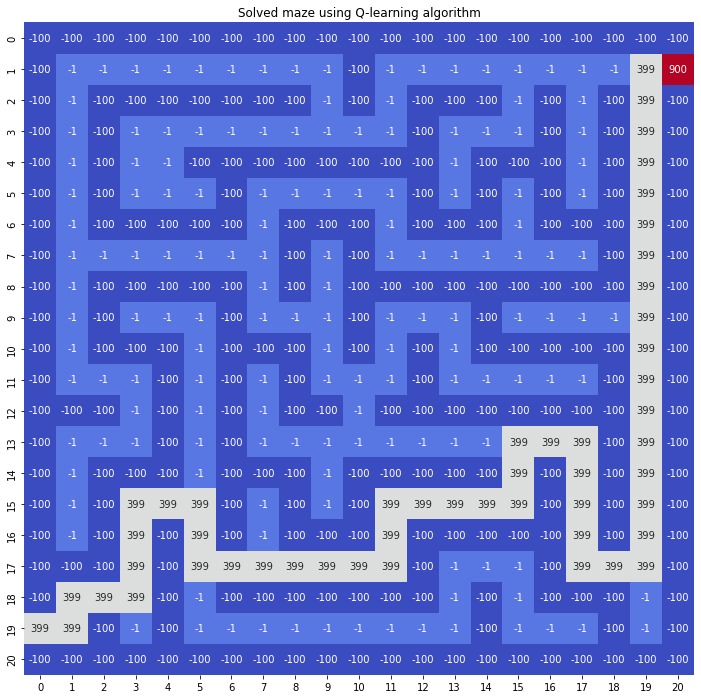

In [5]:
def get_shortest_path(start_position, q_values):
    """
    Returns the coordintes of the tiles in the shortest path from start_position to the end of the maze
    The shortest path is defined as the one that maximizes the rewards collected by the agent
    """
    current_pos = start_position
    path = [current_pos]

    it = 0
    while not is_terminal_position(current_pos) and it < 150:
        action = np.argmax(q_values[current_pos])
        new_pos = move(current_pos, action)
        path.append(new_pos)
        current_pos = new_pos
        
        it+=1

    return path

# starting_pos = new_starting_position()
starting_pos = (19, 0)
print(f'Starting position : {starting_pos}')
path = get_shortest_path(starting_pos, q_values)

# Display path
show_path(path, title='Solved maze using Q-learning algorithm')

## SARSA training loop

**on-policy** : Target and behaviour policies (can be) are the same

**Temporal difference** 

$$TD_t(a_t,s_t)=r_t+\gamma\, Q(a_{t+1},s_{t+1})-Q(a_t,s_t)$$

where $a_{t+1} \sim W_{s_{t+1}}=Softmax^\tau (Q(s_{t+1},.))$

**(Personal) Observations**

This policy requires a high discount value  ($\simeq 1$) to converge. So it needs more exploration than Q-learning

In [10]:
lr = 0.5 # Learning rate
discount = 0.9
n_episodes = 10_000
max_iter = 150

# Initial state (function to learn)
q_values_sarsa = np.zeros((n_rows, n_cols, len(actions)))


for episode in tqdm(range(n_episodes)):

    # s_t (start from a random position at the beginning of each episode)
    current_position = new_starting_position()

    # Q-values for current state s_t
    possible_q_values = q_values_sarsa[current_position]

    # a_t : [0, 1, 2, 3]
    Ws = softmax(possible_q_values)
    action = np.random.choice(np.arange(len(actions)), p=Ws)

    it = 0
    while not is_terminal_position(current_position) and it < max_iter:

        # Q(a_t,s_t)
        q_value = possible_q_values[action]

        # s_(t+1)
        next_position = move(current_position, action)

        # r_t = R(a_t, s_t)
        reward = terrain[next_position]

        # Q-values for state s_(t+1)     (redefine possible_q_values)
        possible_q_values = q_values_sarsa[next_position]

        # a_(t+1)   (redefine Ws and action)
        Ws = softmax(possible_q_values, tau=0.5)
        next_action = np.random.choice(np.arange(len(actions)), p=Ws)

        # Q(a_(t+1),s_(t+1))
        next_q_value = possible_q_values[next_action]

        # Temporal Difference TD(a_t,s_t)
        temporal_difference = TD(reward, next_q_value, q_value, discount=discount)

        # Update Q(a_t, s_t)
        new_q_value = q_value + lr * temporal_difference
        q_values_sarsa[current_position + (action,)] = new_q_value

        # Update position
        current_position = next_position
        # Update action
        action = next_action

        it+=1

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:20<00:00, 491.50it/s]


Starting position : (19, 0)


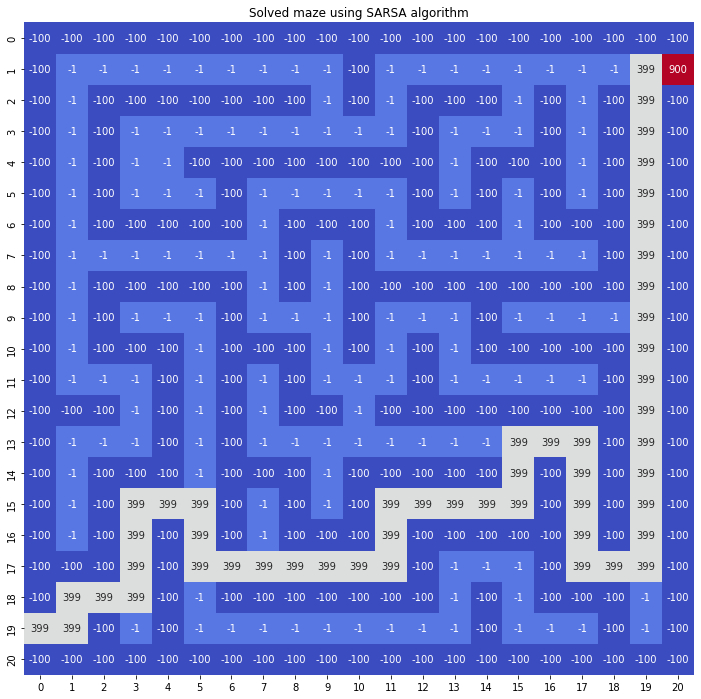

In [11]:
# starting_pos = new_starting_position()
starting_pos = (19,0)
print(f'Starting position : {starting_pos}')
path = get_shortest_path(starting_pos, q_values_sarsa)

# Display path
show_path(path, title='Solved maze using SARSA algorithm')

## Cliff World (WIP)

The aim of this experiment is to illustrate the difference of behaviour between an agent trained with Q-learning and an agent trained using the SARSA approach.

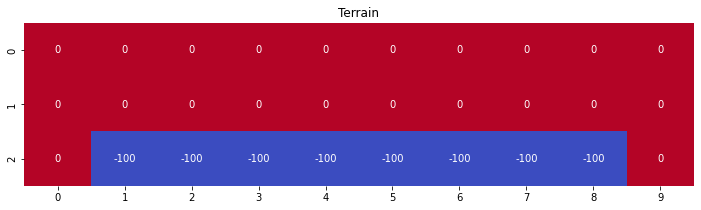

In [3]:
n_row = 3
n_col = 10
terrain = np.full((n_row, n_col), 0)
terrain[-1,1:-1] = -100
terrain[-1,-1] = 0

start_point = (2, 0)
end_point = (2, 9)

plt.figure(figsize=(12, 3))
plt.title('Terrain')
sns.heatmap(terrain, cbar=False,  annot=True, fmt='.0f', cmap='coolwarm')
plt.show()

In [ ]:
def is_terminal_position(position):
    return terrain[position] == -100  or position == end_point